In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from csaps import csaps

%config InlineBackend.figure_formats = ['svg']

units are always mK, pJ, pW, Ohm, H, muA, V, s, Hz, mm, keV, g, ...

In [2]:
tes_rt0 = {'li1p': 0.110, 'li1l': 0.115, 'li2p': 0.100, }  # Ohm

utils_par = {
    'bath_temperature': 11,  # mK
    'Rh': 10,  # Ohm
    'Rs': 0.040,  # Ohm
    'L': 3.5e-7, # H 
            }

# extract thermalization times from pulse shape

In [3]:
path = '../../rltest_data/'

names = ['li1p', 'li1l', 'li2p']

sev = {'li1p': np.loadtxt(path + 'Channel_0_SEV_Particle.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_Direct.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_Particle.xy', skiprows=3)}


## pulse shape fit

In [4]:
def pulse_template(t, t0, An, At, tau_n, tau_in, tau_t):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = (An * (np.exp(-(t[cond] - t0) / tau_n) - np.exp(-(t[cond] - t0) / tau_in)) + \
                   At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))
    return pulse

In [5]:
pspars = {'li1p': [-2.74038416, 1.18433165, 1.04116448, 72.05835566, 0.38244691, 9.35751479], 
          'li1l': [-1.330066039435939, 1.0952134272841865, 0.6847593878712344, 17.83502246386849, 0.09396510359613783, 3.6836775281151417], 
          'li2p': [-2.06154929, 1.1372723, 0.94300337, 79.26274212, 0.39666609, 12.05657907]}

pspars_fit = {}

In [6]:
for name in names:

    def cost_ch1(t0, An, At, tau_n, tau_in, tau_t):
        return np.sum((pulse_template(sev[name][:,0]*1000, t0, An, At, tau_n, tau_in, tau_t) - sev[name][:,1]) ** 2)

    m = Minuit(cost_ch1, *pspars[name])

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator

    pspars_fit[name] = list(m.values)

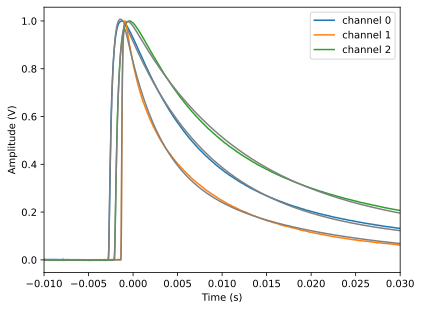

In [7]:
for c,name in enumerate(names):
    plt.plot(sev[name][:,0], sev[name][:,1], label=f'channel {c}')
    plt.plot(sev[name][:,0], pulse_template(sev[name][:,0]*1000, *pspars_fit[name]), color='grey')
    
plt.xlim(-0.01,0.03)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

## transition curve splines

In [8]:
transition_curves = np.loadtxt(path + 'rl_tests.xy', skiprows=5)[2600:10000]

transition_curves = {'li1p': transition_curves[:,[0,1]], 
                     'li1l': transition_curves[:,[0,2]], 
                     'li2p': transition_curves[:,[0,3]]}

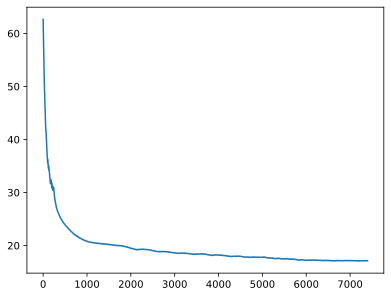

In [9]:
plt.plot(transition_curves['li1p'][:,0])

In [10]:
transition_curves_sorted = {}
transition_curves_cleaned = {}
temp_grids = {'li1p': np.linspace(25,35, 1000),
              'li1l': np.linspace(18,28, 1000),
              'li2p': np.linspace(20,35, 1000),}
transition_curve_splines = {}
transition_curve_derivative_splines = {}
xlims = {'li1p': (29.5,32.5),
         'li1l': (22,24),
         'li2p': (28,32),}

for name in names:
    transition_curves_sorted[name] = np.sort(transition_curves[name], axis=0)

    transition_curves_cleaned[name] = []
    for v in np.unique(transition_curves_sorted[name][:,0]):
        transition_curves_cleaned[name].append(np.mean(
            transition_curves_sorted[name][transition_curves_sorted[name][:,0] == v], axis=0))
    transition_curves_cleaned[name] = np.array(transition_curves_cleaned[name])
    
    transition_curves[name][:,1] = transition_curves[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    transition_curves_cleaned[name][:,1] = transition_curves_cleaned[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    
    transition_curve_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           transition_curves_cleaned[name][:,1], 
                                           temp_grids[name], smooth=0.99999)
    
    transition_curve_derivative_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           np.gradient(transition_curves_cleaned[name][:,1], 
                                                       transition_curves_cleaned[name][:,0]), 
                                           temp_grids[name], smooth=0.9999)

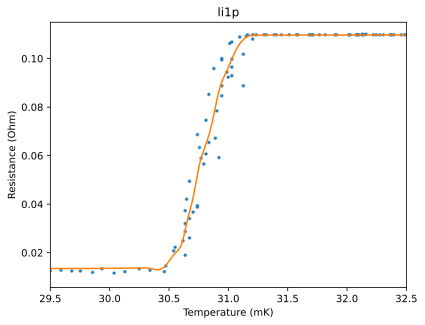

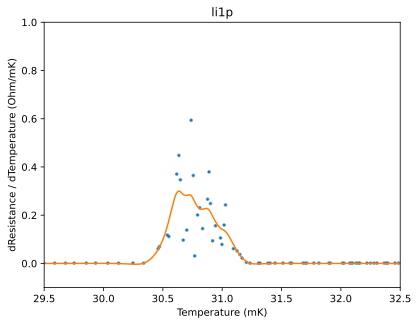

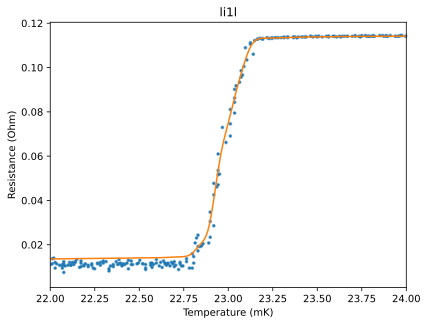

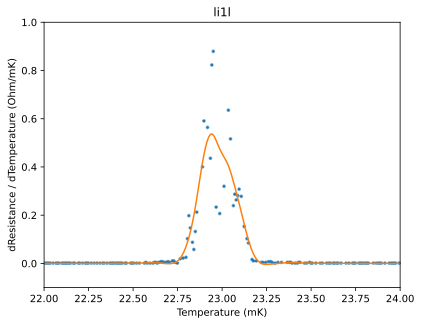

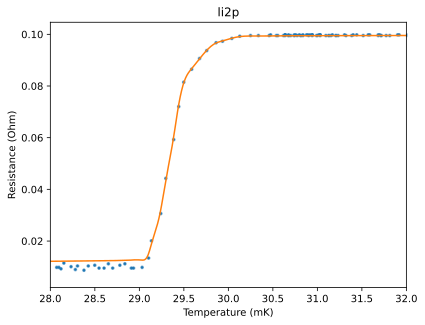

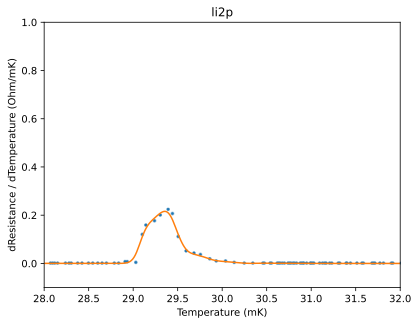

In [11]:
for name in names:
    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.title(name)
    plt.xlim(xlims[name])
    plt.show()
    
    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1)
    plt.show()

## pulse heights in temperature

SQUID sensitivity * 100

U / phi0 8.65

I / phi0 0.15

In [12]:
# for this we need the transition curve and the OP at the point where A_fast was measured
# scale the transition curve to the bias current and get derivative at DAC
# get V/phi_0 from Heater bias client: Phi-0 [Volt / Phi-0]: 8.65
# the input coil sensitivity is then 0.15 muA/phi_0
# therefore 8.65 V PH = 0.15 muA PH * der sensitivity range (zehnerpotenz)
# sensitivity range get from squid client - it is * 100

v_to_muA = 0.15 / 8.65 * 10

In [13]:
# bias currents were: Li1P 2.8, Li1L 0.84, Li2P 3.0
# V_sets were: Li1P 1.55, Li1L 0.287, Li2P 2.5

bias = {'li1p': 0.28 * 17.86, 'li1l': 0.084 * 17.86, 'li2p': 0.336 * 17.86,}
v_sets = {'li1p': 1.55, 'li1l': 0.287, 'li2p': 2.5,} 

In [14]:
# and we need A_fast in term of temperature

I_squid_op = {}
V_op = {}
R_op = {}

for name in names:

    I_squid_op[name] = v_to_muA * v_sets[name]
    V_op[name] = bias[name] / v_to_muA / (utils_par['Rs'] / tes_rt0[name] + 1) - v_sets[name]
    R_op[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1)
    

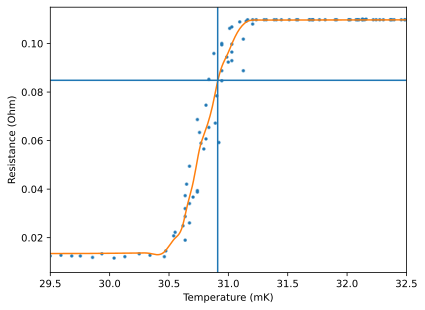

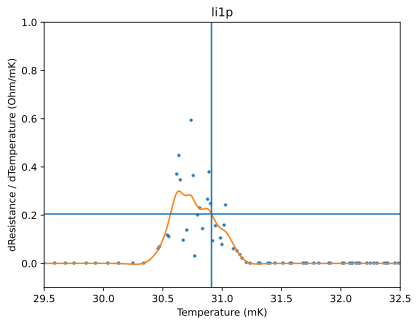

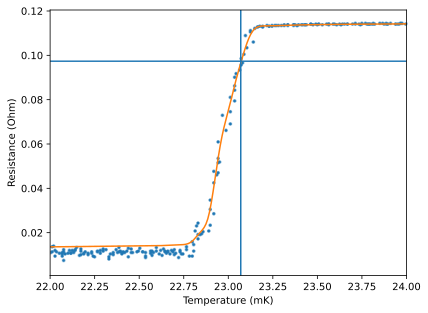

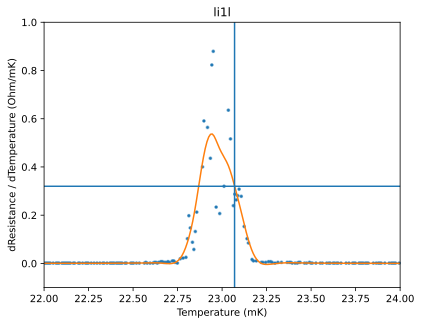

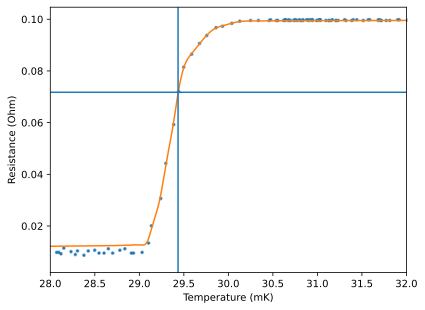

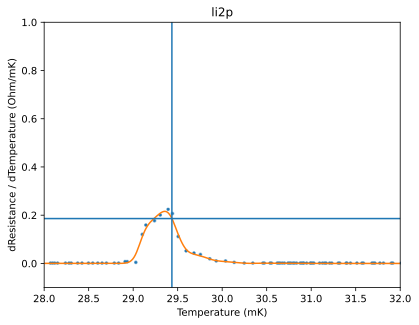

In [15]:
# eval derivative of transition curve at all OPs

T_op = {'li1p': 30.91, 'li1l': 23.07, 'li2p': 29.435}
dRdT_op = {'li1p': 0.205, 'li1l': 0.32, 'li2p': 0.186}

for name in names:

    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.axhline(R_op[name])
    plt.axvline(T_op[name])
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.xlim(xlims[name])
    plt.show()

    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.axvline(T_op[name])
    plt.axhline(dRdT_op[name])
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1)
    plt.show()


In [16]:
# linearize the transition curve:
# around the OP it is roughly R(T + deltaT) = R_op + dRdT_op * deltaT
# we invert to deltaT = (R(T + deltaT) - R_op) / dRdT_op
# but this is also deltaT = (R(Vop + deltaVph) - R_op) / dRdT_op if we can linearize the R function as well

# linearize the function for the resistance:
# R(Vop + deltaVph) = Rref / (Ib / u / (Vop + deltaVph) - 1), with u = (I/phi_0) * (phi0/U) * sensitivitySQUID 
# the derivative for V at the OP is = u * Rref * Ib / (Ib - u * V_op) ** 2
# around the OP it is threfore linearized to R(Vop + deltaVph) = Rref / (Ib / u / Vop - 1) + u * Rref * Ib / (Ib - u * V_op) ** 2 * deltaVph

Vph_iron = {'li1p': 0.37, 'li1l': 3.3, 'li2p': 0.523}
R_iron = {}  # resistance increase for iron events
Tph_iron = {}

for name in names:
    
    R_iron[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1) + v_to_muA * utils_par['Rs'] * bias[name] / (bias[name] - v_to_muA * V_op[name]) ** 2 * Vph_iron[name] 
    Tph_iron[name] = (R_iron[name] - R_op[name]) / dRdT_op[name]


# calc detector properties

In [17]:
# below are constants of nature

kB = 1.380649e-17  # mm ^ 2 * g / s^2 / mK     # nJ / mK
na = 6.02214076e23  # number of items per mole
h_const = 6.62607015e-34  # kg * m^2 / s
e_charge = 1.60217663e-19  # coulombs

In [18]:
density = {'W': 0.01935, 'Au': 0.01932, 'Al': 0.002702, 'CaWO4': 0.00606, 'Si': 0.00233, 'Al2O3': 0.00398, 'LiAlO2': 0.002615, 'Cu': 0.0089, }  # g/mm^3
molar_mass = {'W': 183.84, 'Au': 196.96655, 'Al': 26.981538, 'CaWO4': 287.9156, 'Si': 28.0855, 'Al2O3': 101.961276, 'LiAlO2': 65.92, 'Cu': 63.546, }  # g/mole

energy_gap = {'CaWO4': 5.2e-3, 'Si': 1.12e-3, 'Al203': 8.3e-3, 'LiAlO2': 4.59, 'Cu': 0.0, }  # keV
sommerfeld_constant = {'W': 1.01e3, 'Au': 0.729e3, 'Al': 1.356e3, 'Cu': 0.7e3, }  # pJ / mol / mK^2 ; gold value is from Florians book
fermi_temp = {'W': 27_000_000, 'Au': 63_900_000, 'Al': 134_900_000, 'Cu': 8_160_000, }  # mK
electron_phonon_coupling = {'W': 2.1e-4}  # pW / mK^6 / mm^3 - multiply with T^5 (mK) and volume (mm^3)
thermal_conductivity = {'Au': 17.1e3}  # pW / mK^2 / mm - multiply with temperature (mK) and cross section (mm^2), divide by length (mm) 


In [19]:
# speed of sound 
K_mod = {'LiAlO2': 94, 'Al2O3': 232, 'Si': 83, 'Cu': 39,}  # bulk modulus, GPa
G_mod = {'LiAlO2': 53, 'Al2O3': 149, 'Si': 63, 'Cu': 53,}   # shear modulus, GPa
s_long = {}
s_trans = {}
s_eff = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:

    s_long[name] = np.sqrt( (K_mod[name] + 4/3*G_mod[name]) / density[name] * 1e3 ) # sqrt( 10**6 / s ** 2 / mm * mole )
    s_trans[name] = np.sqrt( G_mod[name] / density[name] * 1e3)  # sqrt( 10**6 / s ** 2 / mm * mole )
    s_eff[name] = ((1/3) * s_long[name] ** (-3) + (2/3) * s_trans[name] ** (-3) ) ** ( - 1 / 3)  # m/s
    

In [20]:
# atomic density lithium aluminate
n_atom = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    n_atom[name] = density[name] / (molar_mass[name] / na) * 1e9  # 1/m^3
    print(name, n_atom[name])

LiAlO2 2.388940850637136e+28
Al2O3 2.3507081477481704e+28
Si 4.996025696818643e+28
Cu 8.43437081232493e+28


In [21]:
# Debye freqency is ω^3_D=6π^2nc^3. (https://lampx.tugraz.at/~hadley/ss1/phonons/table/dosdebye.html)

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_eff[name] ** 3) ** (1/3)  # rad / sec
    print('deb freq', name, deb_freq*1e-12/2/np.pi, 'in THz')
    # print(name, deb_freq * h_const / kB, 'in mK')
    td = deb_freq/2/np.pi * h_const / kB * 1e9 # mK
    print('deb temp', name, td, 'in mK')
    
# debye model phonon heat resistance
# http://lampx.tugraz.at/~hadley/ss2/transport/phonon_Boltzmann.php

deb freq LiAlO2 8.943137886280796 in THz
deb temp LiAlO2 429202.92554892146 in mK
deb freq Al2O3 12.051032854168913 in THz
deb temp Al2O3 578358.3595227894 in mK
deb freq Si 13.111905093419978 in THz
deb temp Si 629272.1969823111 in mK
deb freq Cu 7.216316271648248 in THz
deb temp Cu 346328.5588192781 in mK


In [22]:
# below are constants of the materials

debye_frequency = {'CaWO4': 4.7, 'Si': 13.5, 'Al2O3': 21.7,  # from pantic thesis , THz
                   'LiAlO2': 8.94, 'Cu': 7.22, }  # calc above
                # mK  # debye_temp * h_const / kB
debye_temp = {'W': 383_000, 'Au': 162_000, 'Al': 428_000, 'CaWO4': 228_000, 'Si': 648_000, 'Al2O3': 1_041_000,  # from pantic thesis 
              'LiAlO2': 429_202, 'Cu': 346_328, }  # mK  # calc above


In [23]:
abs_material = {'li1p': 'LiAlO2', 'li1l': 'Al2O3', 'li2p': 'LiAlO2', }
abs_volume = {'li1p': 4000, 'li1l': 200, 'li2p': 4000, }  # mm^3
abs_surface = {'li1p': 1600, 'li1l': 840, 'li2p': 1600, }  # mm^2
tes_thickness = {'li1p': 0.0002, 'li1l': 0.0002, 'li2p': 0.0002, }  # mm
tes_surface = {'li1p': 2.6, 'li1l': 0.072, 'li2p': 2.6, }  # mm^2 
pc_surface = {'li1p': 15.96, 'li1l': 1.01, 'li2p': 15.96, }  # mm^2
tes_tc = {'li1p': 31, 'li1l': 22.5, 'li2p': 29, }  # mK
tes_width = {'li1p': 1, 'li1l': 1.7, 'li2p': 1.5, }  # mK
thermal_link_width = {'li1p': 0.040, 'li1l': 0.040, 'li2p': 0.040, }  # mm
thermal_link_thickness = {'li1p': 0.000080, 'li1l': 0.000080, 'li2p': 0.000080, }  # mm
thermal_link_length = {'li1p': 0.61, 'li1l': 1., 'li2p': 0.61, }  # mm


## heat capacity absorber phonons and TES electrons

In [24]:
Cph_mm3 = {}  # pJ / mK / mm^3
Ce_mm3 = {}  # pJ / mK / mm^3
Cph = {}  # pJ / mK
Ce = {}  # pJ / mK

for name in names:
    mat = abs_material[name]
    n_mol_mm3 = density[mat] / molar_mass[mat] 
    Cph_mm3[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol_mm3 * 1e3
    
    n_mol = abs_volume[name] * density[mat] / molar_mass[mat] 
    Cph[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3
    
    n_mol_mm3 = density['W'] / molar_mass['W']
    Ce_mm3[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol_mm3 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W']
    Ce[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol 

In [25]:
Cph

{'li1p': 0.11520496796414059,
 'li1l': 0.00016516321135009383,
 'li2p': 0.09948699489302736}

In [26]:
Ce

{'li1p': 0.0022676203708563753,
 'li1l': 4.306943468078209e-05,
 'li2p': 0.0022845997149528504}

## electron - phonon coupling

In [27]:
eph_coupling = {}

for name in names:
    eph_coupling[name] = electron_phonon_coupling['W'] * T_op[name] ** 5 * tes_surface[name] * tes_thickness[name] 
    

In [28]:
eph_coupling

{'li1p': 3.081184210701722,
 'li1l': 0.019761493299104083,
 'li2p': 2.412919532913598}

## bath coupling TES

In [29]:
thermal_link = {}

for name in names:
    thermal_link[name] = thermal_conductivity['Au'] * (T_op[name] + utils_par['bath_temperature'])/2 * thermal_link_width[name] * thermal_link_thickness[name] / thermal_link_length[name] 

In [30]:
thermal_link

{'li1p': 1.8797665573770492,
 'li1l': 0.9321552000000001,
 'li2p': 1.813609180327869}

## copper holders

In [31]:
tau_holder = {'li1p': 200, 'li1l': 100, 'li2p': 200,}
volume_holder = dict([(name, 400) for name in names])

C_holder = {}

for name in names:
    mat = 'Cu'
    n_mol = volume_holder[name] * density[mat] / molar_mass[mat] 
    C_holder[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3

G_holder = dict([(name, C_holder[name]/tau_holder[name]) for name in names])

In [32]:
C_holder

{'li1p': 0.07741781281321224,
 'li1l': 0.03218745698221213,
 'li2p': 0.06685532476667837}

In [33]:
G_holder

{'li1p': 0.0003870890640660612,
 'li1l': 0.0003218745698221213,
 'li2p': 0.00033427662383339184}

## calc thermalization times

In [34]:
# tau_film and tau_crystal from tau_n = ( 1/tau_film + 1/tau_crystal )^-1
# and tau_film from A_fast = epsilon E / Ce and epsilon = tau_film / (tau_film + tau_crystal)
# this gives tau_film = (1 + beta) tau_n and tau_crystal = (1 + beta) / beta tau_n
# with beta = E / A_fast / Ce - 1

In [47]:
Afast = {'li1p': 0.89, 'li1l': 1.041, 'li2p': 0.943}  # for PH = 1, therefore just multiplicative factor to any PH
tau_rise = {'li1p': 0.000382, 'li1l': 0.000174, 'li2p': 0.000397}  # s, 

In [52]:
tau_film = {}
tau_crystal = {}
epsilon = {}

for name in names:
    energy = (5.9 * 8/9 + 1/9 * 6.4)  # keV
    energy *= 0.000160218 # pJ
    beta = energy / Afast[name] / Tph_iron[name] / Ce[name] - 1
    tau_film[name] = (1 + beta) * tau_rise[name]
    tau_crystal[name] = (1 + beta) / beta * tau_rise[name]
    epsilon[name] = tau_film[name] / (tau_film[name] + tau_crystal[name])

In [53]:
epsilon

{'li1p': 0.9484244557599568,
 'li1l': 0.973586411465644,
 'li2p': 0.9427296931304543}

In [61]:
therm_crystal_const = {}
therm_film_const = {}

for name in names:
    therm_crystal_const[name] = 1e3 * s_eff[abs_material[name]] * abs_surface[name] / abs_volume[name] * tau_crystal[name]
    therm_film_const[name] = 1e3 * s_eff[abs_material[name]] * (tes_surface[name] + pc_surface[name]) / abs_volume[name] * tau_film[name]
    

In [63]:
therm_crystal_const

{'li1p': 806.4391585805184,
 'li1l': 5090.318274209854,
 'li2p': 843.1683759580484}

# extract tes fluct and emi from nps

In [ ]:
# noise functions

In [ ]:
# nps above and below transition?? Is 1/f there in both?

In [ ]:
# nps of long empty trace - does 1/f noise have lower cutoff?

In [ ]:
path = '../../rltest_data/'

nps_ch1 = np.loadtxt(path + 'Channel_0_NPS.xy', skiprows=3)
nps_ch2 = np.loadtxt(path + 'Channel_1_NPS.xy', skiprows=3)
nps_ch6 = np.loadtxt(path + 'Channel_5_NPS.xy', skiprows=3)

transition_curves = np.loadtxt(path + 'rl_tests.xy', skiprows=5)

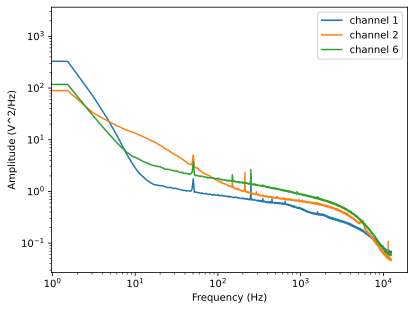

In [57]:
for nps,c in zip([nps_ch1, nps_ch2, nps_ch6], [1,2,6]):
    plt.loglog(nps[:,0], nps[:,1], label=f'channel {c}')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V^2/Hz)')
plt.show()

In [ ]:
# TODO find correct conversion factor from this NPS, produced with the default numpy mode, to the actual physical units!

In [ ]:
# TODO noise formulas

# calc expected noise and fit other components

In [ ]:
# tes_fluct is the prefactor of the 1/f noise component
# emi is the prefactor of the 50 Hz peak

In [ ]:
tes_fluct = {'li1p': ..., 'li1l': ..., 'li2p': ..., }  # ?
emi = {'li1p': ..., 'li1l': ..., 'li2p': ..., }  # ?

# pars dict

In [ ]:
pars = {
    'C': ,  # pJ / mK, is defined later bec mutable
    'Gb': np.array([5e-3, 5e-3]),  # pW / mK
    'G': np.array([[0., 1e-3], [1e-3, 0.], ]),  # heat cond between components, pW / mK
    'lamb': 0.003,  # thermalization time (s)
    'eps': np.array([[0.99, 0.01], [0.1, 0.9], ]),  # share thermalization in components
    'delta': np.array([[0.02, 0.98], ]),  # share thermalization in components
    'Rs': np.array([0.035]),  # Ohm
    'Rh': np.array([10]),  # Ohm
    'L': np.array([3.5e-7]),  # H
    'Rt0': np.array([0.2]),  # Ohm
    'k': np.array([2.]),  # 1/mK
    'Tc': np.array([15.]),  # mK
    'Ib': np.array([1.]),  # muA
    'dac': np.array([0.]),  # V
    'pulser_scale': np.array([1.]),  # scale factor
    'heater_attenuator': np.array([1.]),
    'tes_flag': np.array([True, False], dtype=bool),  # which component is a tes
    'heater_flag': np.array([False, True], dtype=bool),  # which component has a heater
    'i_sq': np.array([2 * 1e-12]),  # squid noise, A / sqrt(Hz)
    'tes_fluct': np.array([2e-4]),  # ??
    'emi': np.array([2e-10]),  # ??
    'Tb': None,  # function that takes one positional argument t, returns Tb
    'tau': np.array([10]),
}


# test with cryosig